# Loading NYU Data

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset

import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np

import timeit

In [5]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU


class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # \"flatten\" the C * H * W values into a single vector per image
    

class Unflatten(nn.Module):
    def __init__(self,w,h):
        super(Unflatten,self).__init__()
        self.w=w
        self.h=h
    def forward(self, x):
        N, S = x.size() # read in N, C, H, W
        return x.view(N, self.w, self.h)  # \"flatten\" the C * H * W values into a single vector per image


In [40]:
import h5py
import scipy.misc as misc

data = h5py.File("../Data/nyu_depth_v2_labeled.mat")
depths = data['depths'][:];
N,W,H=depths.shape
rW=74
rH=55
resized_depths=np.zeros((N,rW,rH))
print('resizing depths images')
for i in range(N):
    resized_depths[i,:,:]=misc.imresize(depths[i,:,:],(rW,rH))
rand_idx=np.random.permutation(N)
resized_depths=resized_depths[rand_idx]
depths_pytorch = torch.from_numpy(resized_depths);
print(depths_pytorch.size())
images = data['images'][:];
images=images[:,:,16:-16:2,12:-12:2]
iamges=images[rand_idx]
images_pytorch = torch.from_numpy(images);
print(images_pytorch.size())
images_pytorch = images_pytorch.float()
depths_pytorch = depths_pytorch.float()
dataset=TensorDataset(images_pytorch,depths_pytorch)
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = int(N*0.8)
NUM_VAL = N-NUM_TRAIN
print("NUM_TRAIN:",NUM_TRAIN,",NUM_VAL:",NUM_VAL)
batch_size=32
loader_train = DataLoader(dataset, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_val = DataLoader(dataset, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

resizing depths images
torch.Size([1449, 74, 55])
torch.Size([1449, 3, 304, 228])
NUM_TRAIN: 1159 ,NUM_VAL: 290


In [6]:
print(resized_depths.shape)
print(np.min(resized_depths[:,:,:]))

NameError: name 'resized_depths' is not defined

In [7]:
dtype = torch.cuda.FloatTensor
coarse_model=nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(3,96,11,stride=4),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(96,256,5,padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(256,384,3,padding=1),
        nn.ReLU(),
        nn.Conv2d(384,384,3,padding=1),
        nn.ReLU(),
        nn.Conv2d(384,256,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        Flatten(),
        nn.Linear(13824,4096),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(4096,4070),
        Unflatten(74,55)
    )
coarse_model.type(dtype)

Sequential (
  (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  (3): ReLU ()
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (7): ReLU ()
  (8): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (9): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU ()
  (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU ()
  (13): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU ()
  (15): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (16): Flatten (
  )
  (17): Linear (13824 -> 4096)
  (18): Dropout (p = 0.5)
  (19): ReLU ()
  (20): Linear (4096 -> 4070)
  (21): Unflatten (
  )
)

In [8]:
x_val=images_pytorch[NUM_TRAIN:,:,:,:]
y_val=depths_pytorch[NUM_TRAIN:,:,:]
print(x_val.size())
print(y_val.size())

NameError: name 'images_pytorch' is not defined

In [16]:
def RMSE_log_neg(pred,y):
    print(pred.size())
    eps = 1e-5
    mask_pos = pred >= 0
    pred_pos = torch.IntTensor(pred.size()).zero_()
    pred_pos[mask_pos] = 1
    torch.addcmul(pred_pos, pred_pos, pred, value = 1.0, out=None) 
    print(pred_pos)
    
    
    pos_num = (mask_pos == True).sum().type(dtype)
    d = (pred[mask_pos]+eps).log() - (y[mask_pos]+eps).log()
    print(pos_num)
    loss_1 = d.pow(2).sum() / pos_num + 0.5/pos_num**2 * d.sum()**2
    loss_2 = 0
    #mask_neg = pred < 0
    #loss_2 = -pred[mask_neg].sum()
    return loss_1 + loss_2
    
y = np.array([[1,2,3],[4,5,6]])
pred = np.array([[-1,2,4],[4,6,7]])
print(RMSE_log_neg(torch.from_numpy(pred).float(),torch.from_numpy(y).float()))

torch.Size([2, 3])


TypeError: torch.addcmul received an invalid combination of arguments - got (torch.IntTensor, torch.IntTensor, torch.FloatTensor, out=NoneType, value=float), but expected one of:
 * (torch.IntTensor source, torch.IntTensor tensor1, torch.IntTensor tensor2, *, torch.IntTensor out)
 * (torch.IntTensor source, int value, torch.IntTensor tensor1, torch.IntTensor tensor2, *, torch.IntTensor out)
      didn't match because some of the keywords were incorrect: value


In [51]:
print_every=100
lr=1e-5
reg=1e-4
adam_optim=optim.Adam(coarse_model.parameters(),lr=lr,weight_decay=reg)

# images_var=Variable(images_pytorch.type(dtype),requires_grad=False)
depths_var=Variable(depths_pytorch.type(dtype),requires_grad=False)
def RMSE_log(pred,y):
#     print(-pred.min()+1)
    pred=(pred-pred.min().expand(pred.size()))+(1)
#     pred=pred+1
    print("min",pred.min().data,",max",pred.max().data)
    N,W,H=pred.size()
    log_pred=pred.log()
    y=y-y.min().expand(y.size())+1
    log_y=y.log()
    alpha=(log_y-log_pred).sum()/W/H
    diff=(log_pred-log_y)+alpha.expand(log_y.size())
    return diff.pow(2).sum()


def RMSE_linear(pred,y):
    N,W,H=pred.size()
    return (pred-y).pow(2).sum()/N

def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        model.train() # set the model to training mode, only effect batchnorm and dropout
        avg_loss=0
        num_batches=0
        for t,(x,y) in enumerate(loader_train):
            x_var=Variable(x.type(dtype),requires_grad=False)
            y_var=Variable(y.type(dtype),requires_grad=False)
            pred=model(x_var)
            loss = loss_fn(pred, y_var)
            if (t+1) % print_every==0:
                print('t = %d, loss = %.4f' % (t+1, loss.data[0]))
            avg_loss+=loss.data[0]
            num_batches+=1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        avg_loss/=num_batches
        x_var=Variable(x_val.type(dtype),requires_grad=False)
        y_var=Variable(y_val.type(dtype),requires_grad=False)
        pred=coarse_model(x_var)
        loss=loss_fn(pred,y_var)
        print("epoch:",epoch,"average training loss: ",avg_loss,"validation loss:",loss.data[0])


train(coarse_model,RMSE_log_neg,adam_optim,150)

Variable containing:
 240
[torch.cuda.FloatTensor of size 1 (GPU 0)]



NotImplementedError: 

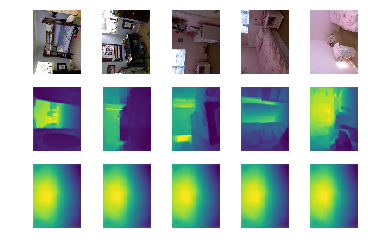

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """

    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# visualize 5 images
NUM_SHOW=5
for t,(x,y) in enumerate(loader_val):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    coarse_model.train(False)
    pred=coarse_model(x_var)
    x_var=x_var.cpu()
    y_var=y_var.cpu()
    pred=pred.cpu()
    for i in range(NUM_SHOW):
        plt.subplot(3,NUM_SHOW,i+1)
        img=x_var[i,:,:,:].data.numpy()
        img=np.rollaxis(img,0,3)
        imshow_noax(img,False)
        plt.subplot(3,NUM_SHOW,NUM_SHOW+i+1)
        img=y_var[i,:,:].data.numpy()
        imshow_noax(img)
        plt.subplot(3,NUM_SHOW,2*NUM_SHOW+i+1)
        img=pred[i,:,:].data.numpy()
        imshow_noax(img)
    break
plt.show()